# 1 Data Wrangling<a id='1_data_wrangling'></a>

In [1]:
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from visuals import *
from helpers import *

# Import API key
from params import lunar_api_key

# set autoreload to 2 so external libraries are reimported each time for changes
%load_ext autoreload
%autoreload 2

## 1.1 Data Collection

The goal of this project is to build a "Crypto"currency Investment recommendation dashboard.  I will be focusing on short-term 7 day rolling window holding period.  I'm fascinated by the social aspect of crypto price influence and my research on this topic landed on [LunarCRUSH](https://lunarcrush.com/about).  LunarCRUSH delivers community insights to crypto investors, funds and exchanges.  Through resource applications and API's, get real-time insights that help make informed crypto investment decisions."  I will be using the assets API endpoint from LunarCRUSH and technical analysis metrics/indicators to make Buy/Hold/Sell recommendations.

In [2]:
# Create base lunarcrush api url
base_url = 'https://api.lunarcrush.com/v2?'

In [3]:
market_params = {'data': 'market',
                 'key': lunar_api_key
                }

market = requests.get(base_url, params=market_params).json()

all_coins = [i['s'] for i in market['data']]

print(len(all_coins))

2197


I will focus on the following 2 coins for this project:

1. Bitcoin (BTC)
2. Dogecoin (DOGE)

Bitcoin is the first decentralized cryptocurrency created in 2009.  Dogecoin is a memecoin that was originally created as a joke but has been in the social media based on support from influencer Elon Musk, Tesla CEO.

In [4]:
# Validate coin symbols exist in data
coins = ['BTC', 'DOGE']
[coin for coin in all_coins if coin in coins]

['DOGE', 'BTC']

In [5]:
# Create api params for assets endpoint
assets_params = {'data': 'assets',
                 'key': lunar_api_key,
                 'symbol': ",".join(coins),
                 'interval': 'day',
                 'change': '1d',
                 'data_points': 720}

assets = requests.get(base_url, params=assets_params).json()

assets['data']

[{'id': 1,
  'name': 'Bitcoin',
  'symbol': 'BTC',
  'price': 34653.44071926,
  'price_btc': 1,
  'market_cap': 649475860217,
  'percent_change_24h': 2.73,
  'percent_change_7d': -9.22,
  'percent_change_30d': -9.92,
  'volume_24h': 36277689557.43,
  'max_supply': '21000000',
  'timeSeries': [{'asset_id': 1,
    'time': 1562371200,
    'open': 11054.0022,
    'close': 11296.620567,
    'high': 11547.131287,
    'low': 11054.0022,
    'volume': 16665937380,
    'market_cap': 199119660789,
    'url_shares': None,
    'unique_url_shares': None,
    'reddit_posts': 309,
    'reddit_posts_score': None,
    'reddit_comments': 4038,
    'reddit_comments_score': None,
    'tweets': 33799,
    'tweet_spam': 3993,
    'tweet_followers': None,
    'tweet_quotes': None,
    'tweet_retweets': None,
    'tweet_replies': None,
    'tweet_favorites': None,
    'tweet_sentiment1': 1098,
    'tweet_sentiment2': 2485,
    'tweet_sentiment3': 6463,
    'tweet_sentiment4': 18382,
    'tweet_sentiment5': 13

The current price and market data is stored in the data key and historical data is stored in the timeSeries key.

In [6]:
# Create DataFrame for each coin and store in dictionary
dfs = {}
for i in range(len(coins)):
    df = pd.DataFrame(assets['data'][i]['timeSeries'])
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('date', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df['name'] = assets['data'][i]['name']
    symbol = assets['data'][i]['symbol']
    df['symbol'] = symbol
    # Store df in dictionary
    dfs[symbol] = df

## 1.2 Data Definition

In [7]:
for coin in coins:
    print(coin,':')
    print(dfs[coin].info())
    print('------------------------------------------')

BTC :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-07-06 to 2021-06-24
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 720 non-null    int64  
 1   time                     720 non-null    int64  
 2   open                     720 non-null    float64
 3   close                    720 non-null    float64
 4   high                     720 non-null    float64
 5   low                      720 non-null    float64
 6   volume                   720 non-null    float64
 7   market_cap               679 non-null    float64
 8   url_shares               667 non-null    float64
 9   unique_url_shares        667 non-null    float64
 10  reddit_posts             720 non-null    int64  
 11  reddit_posts_score       694 non-null    float64
 12  reddit_comments          720 non-null    int64  
 13  reddit_comments_score    694 non-null    float64
 14  t

The maximum history for the lunarCRUSH API is 720 data points but several social media metrics are missing values.  Let's explore that next.

In [8]:
# Gather unique list of columns with missing values
blanks = []
for coin in coins:
    blanks.append(dfs[coin].columns[dfs[coin].isna().any()].tolist())
blanks_set = set([item for sublist in blanks for item in sublist])
blanks_set

{'alt_rank',
 'alt_rank_30d',
 'alt_rank_hour_average',
 'average_sentiment',
 'correlation_rank',
 'galaxy_score',
 'market_cap',
 'market_cap_global',
 'market_cap_rank',
 'market_dominance',
 'medium',
 'news',
 'percent_change_24h_rank',
 'price_score',
 'reddit_comments_score',
 'reddit_posts_score',
 'search_average',
 'sentiment_absolute',
 'sentiment_relative',
 'social_dominance',
 'social_impact_score',
 'social_score',
 'social_score_24h_rank',
 'social_volume_24h_rank',
 'social_volume_global',
 'tweet_favorites',
 'tweet_followers',
 'tweet_quotes',
 'tweet_replies',
 'tweet_retweets',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment3',
 'tweet_sentiment4',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact3',
 'tweet_sentiment_impact4',
 'tweet_sentiment_impact5',
 'tweet_spam',
 'tweets',
 'unique_url_shares',
 'url_shares',
 'volatility',
 'volume_24h_rank',
 'youtube'}

Plot time series plots for the columns with missing values.

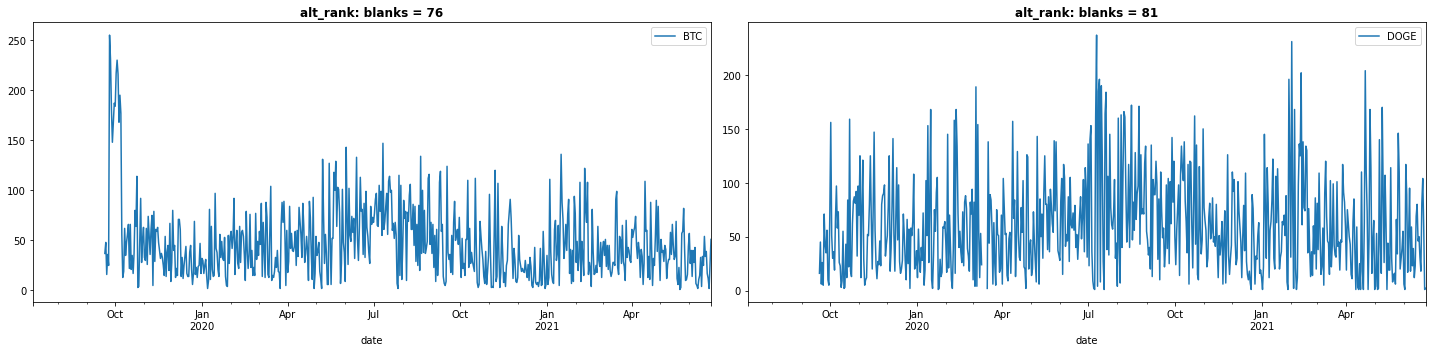

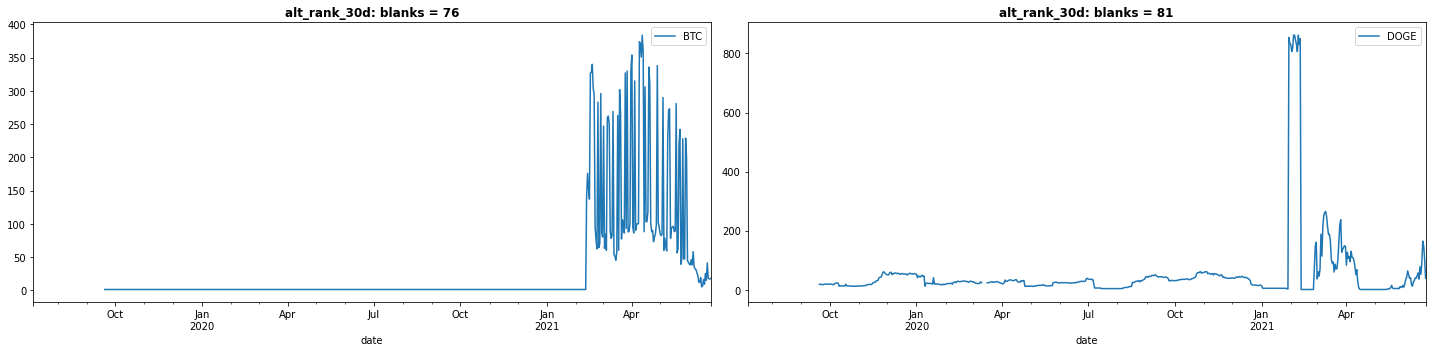

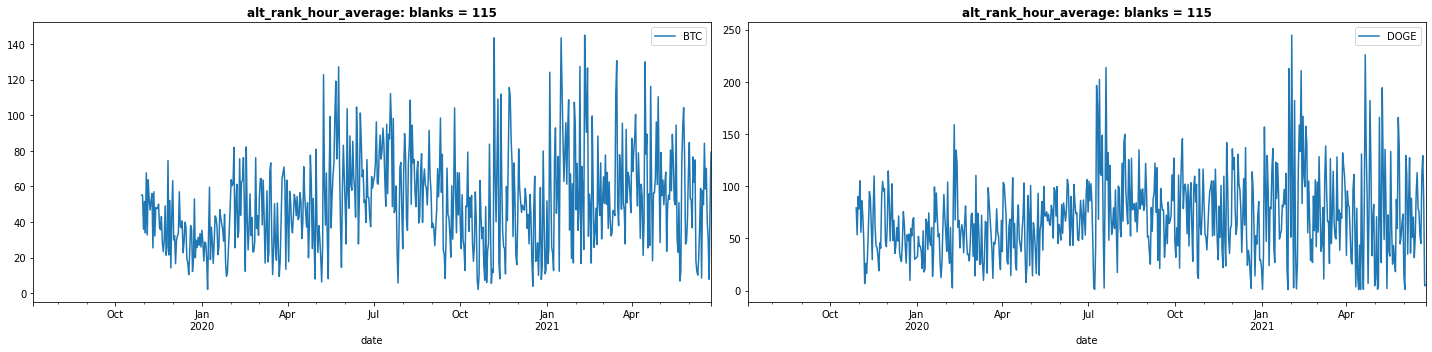

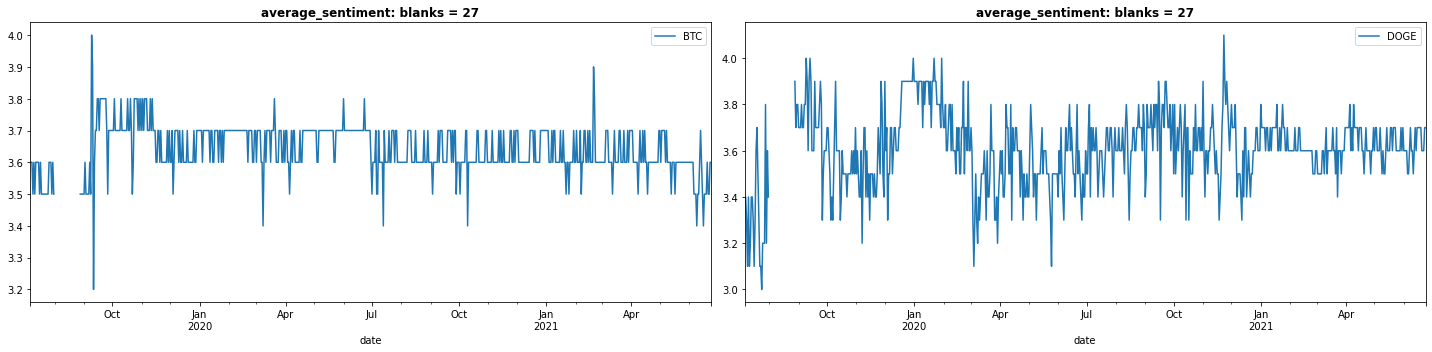

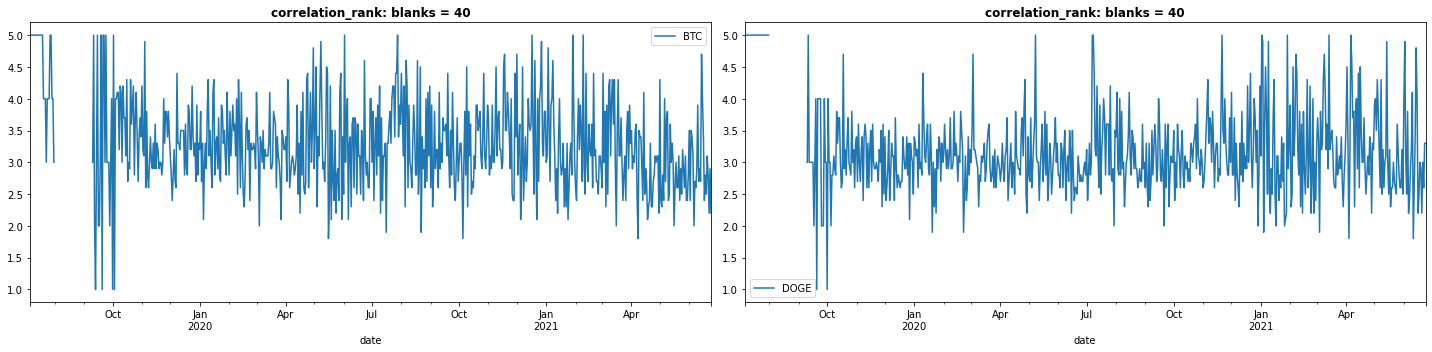

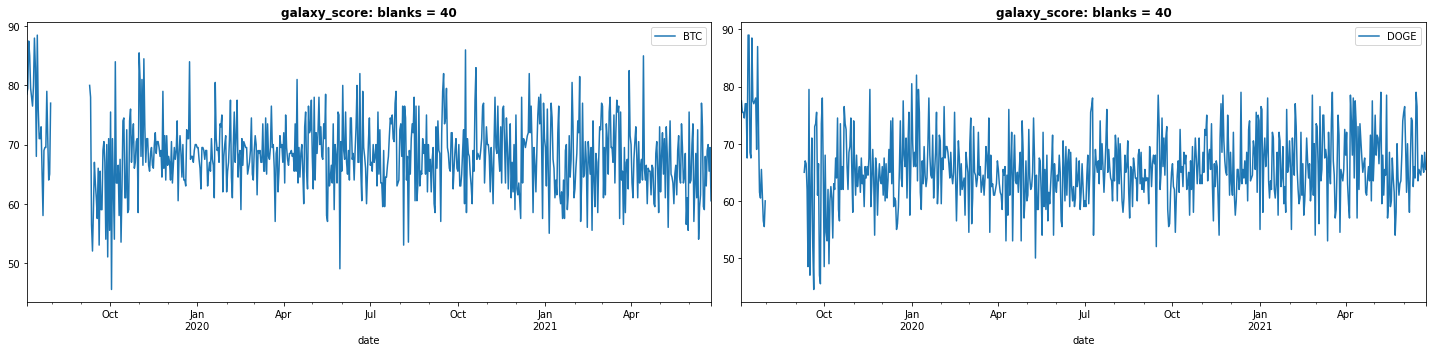

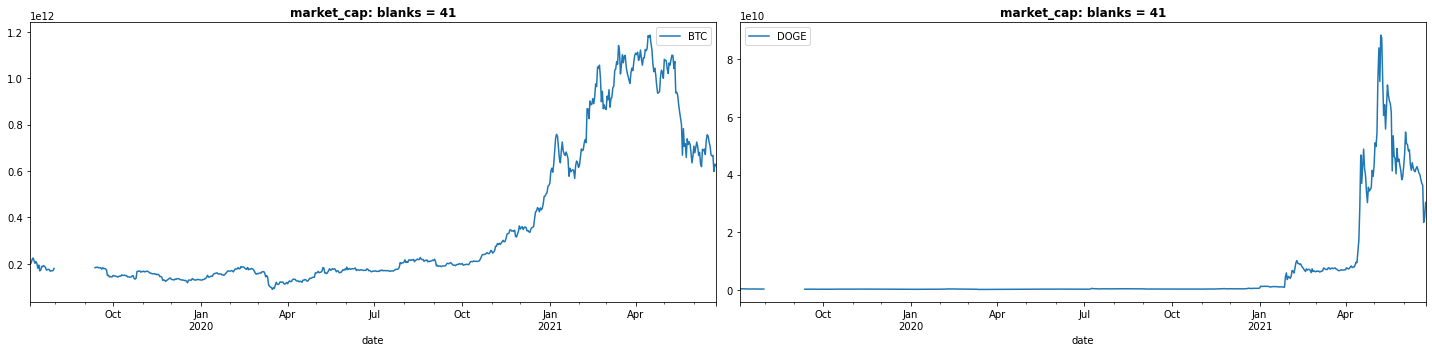

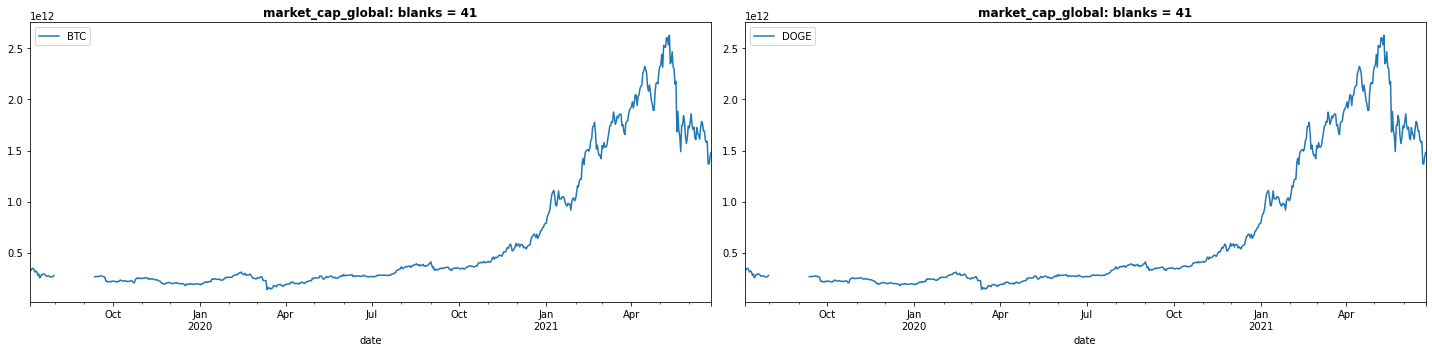

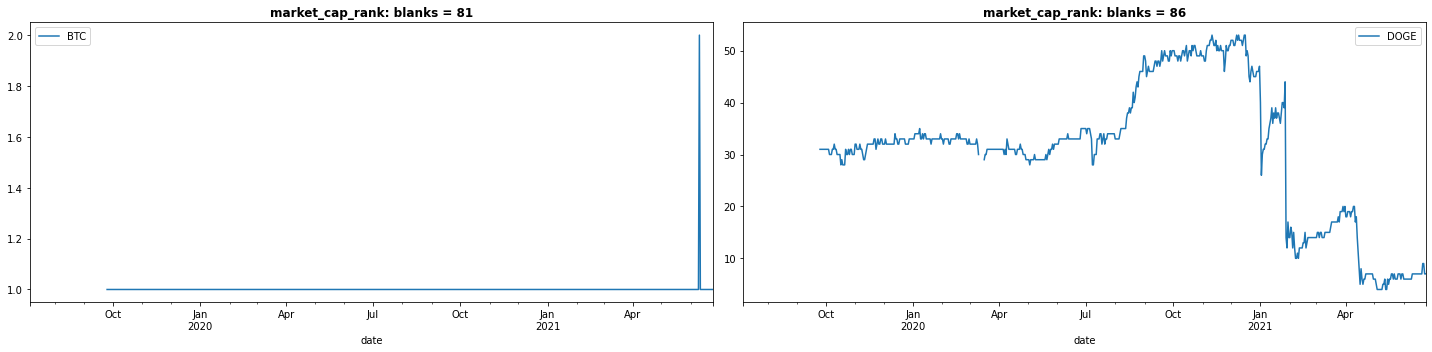

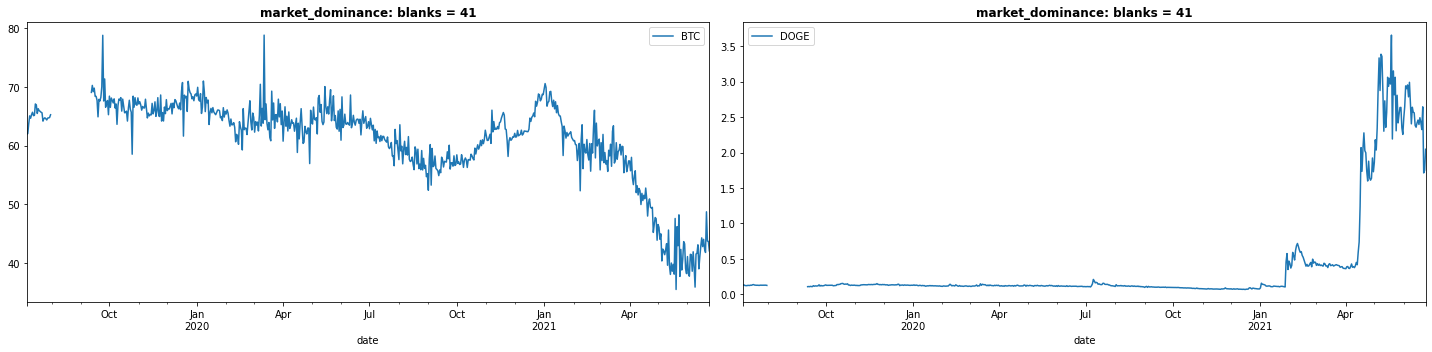

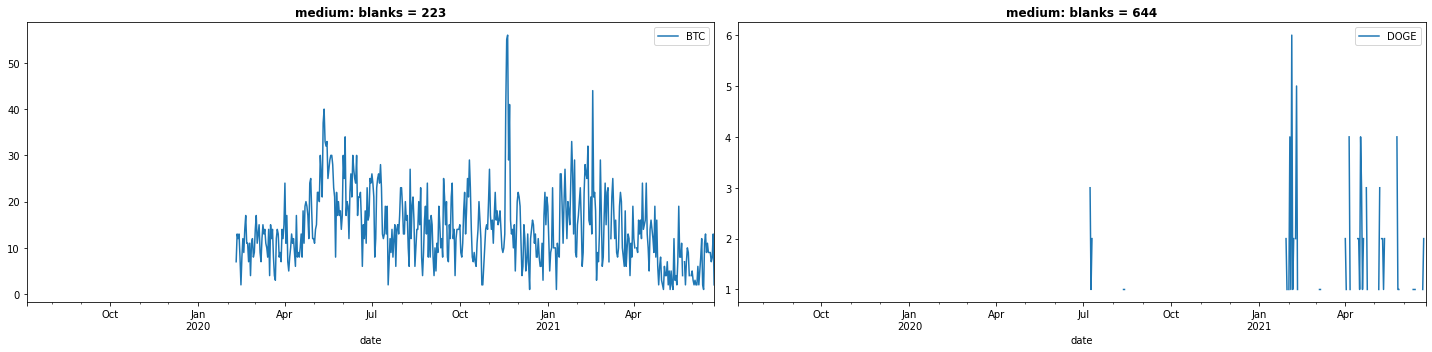

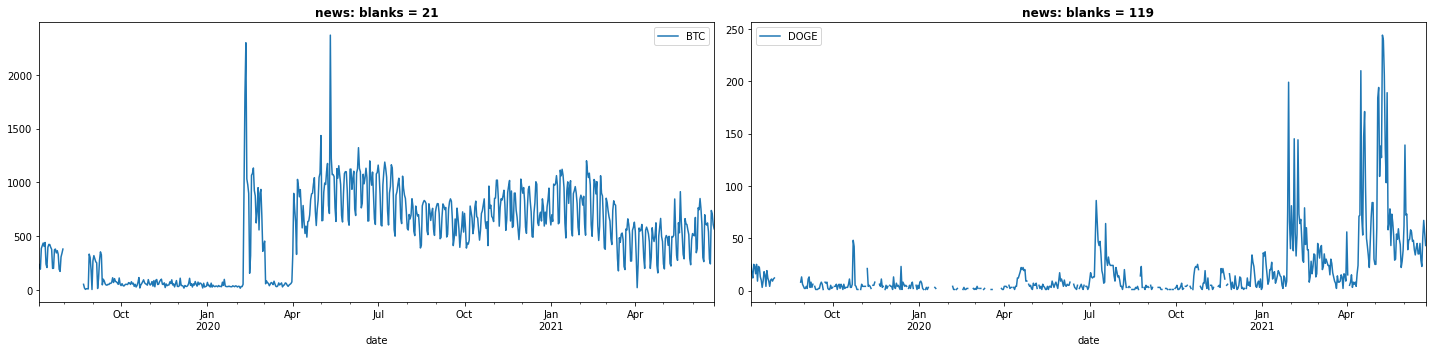

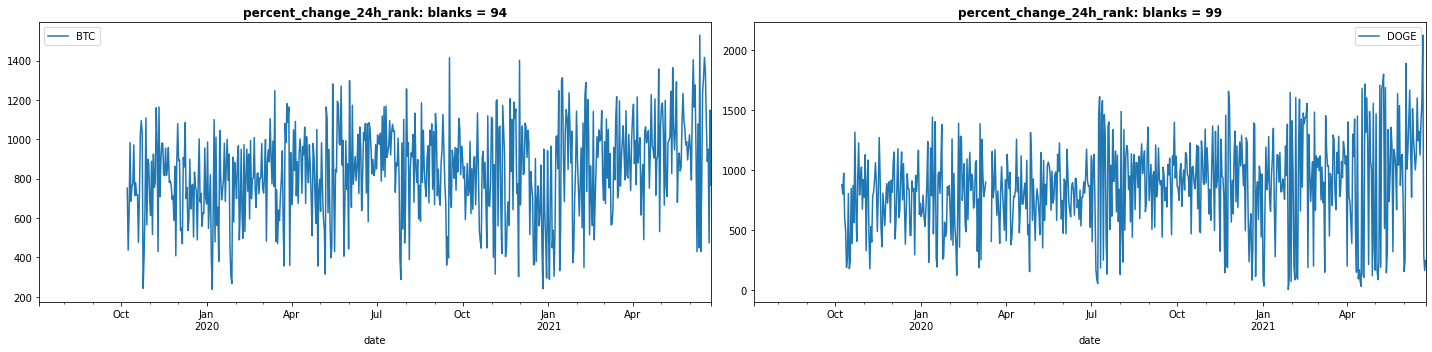

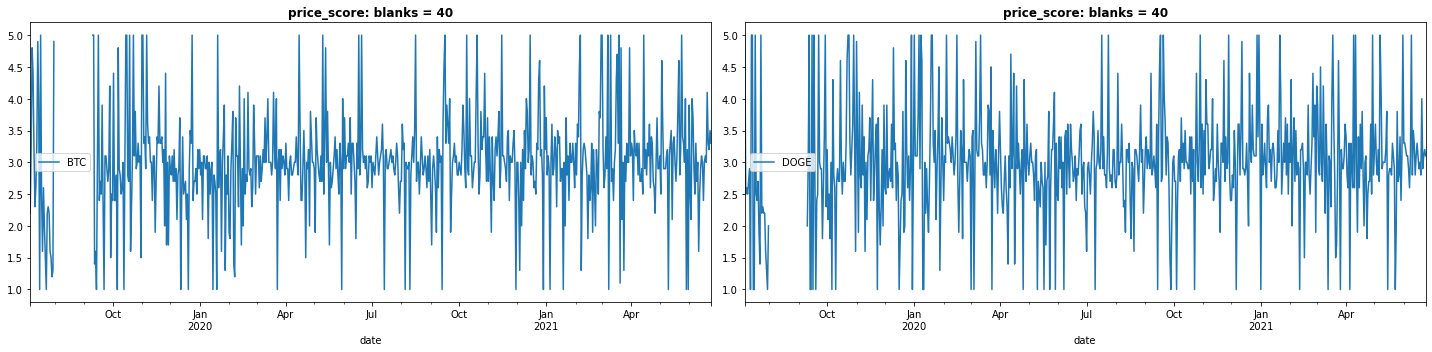

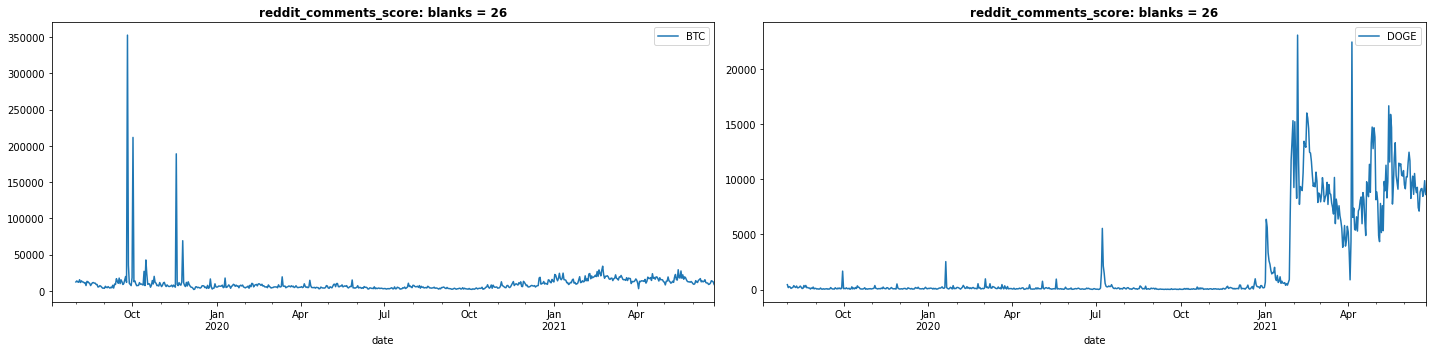

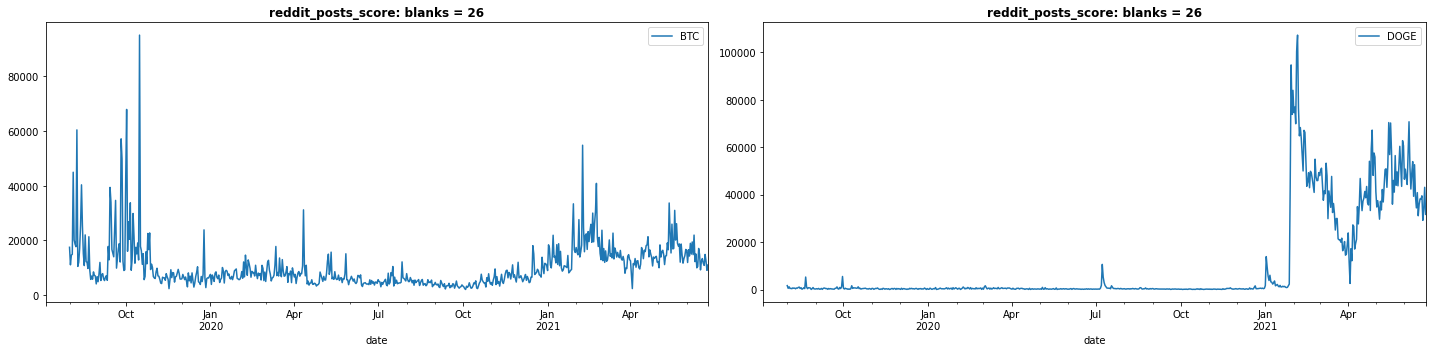

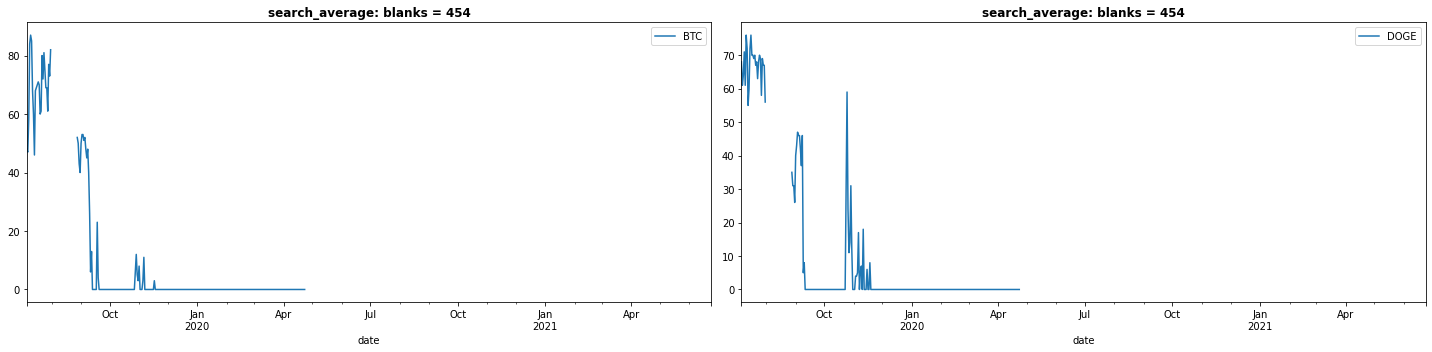

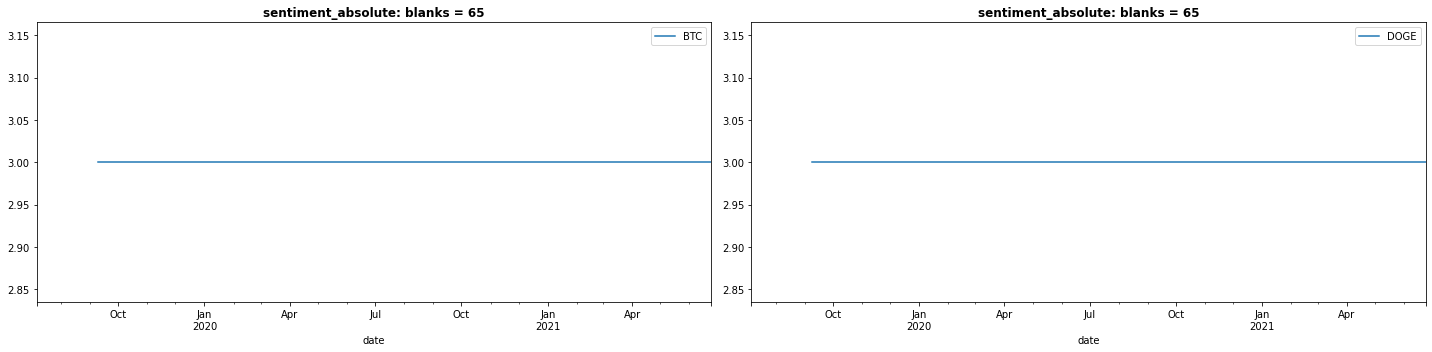

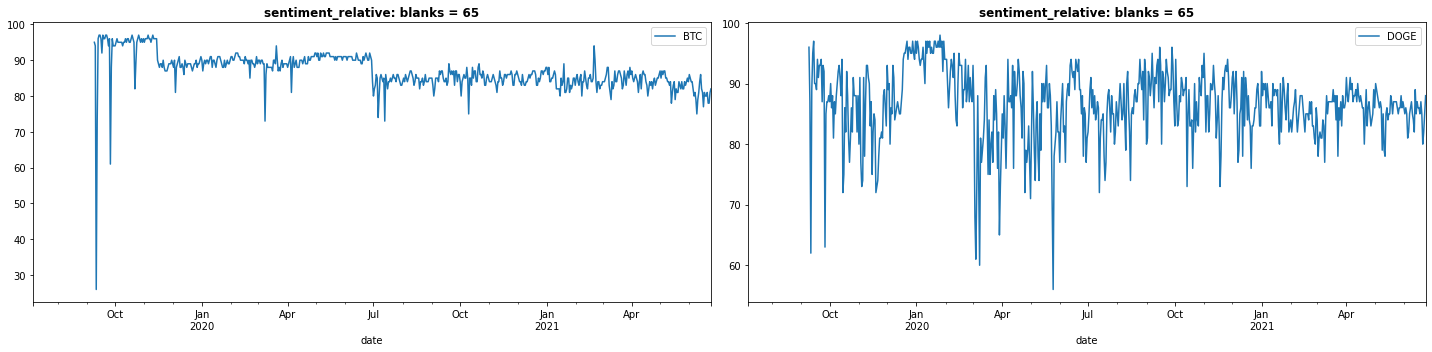

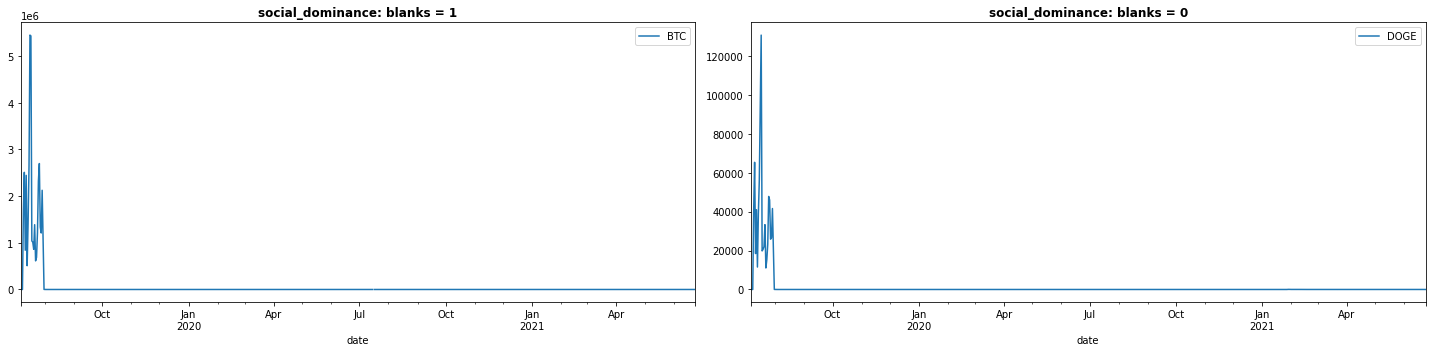

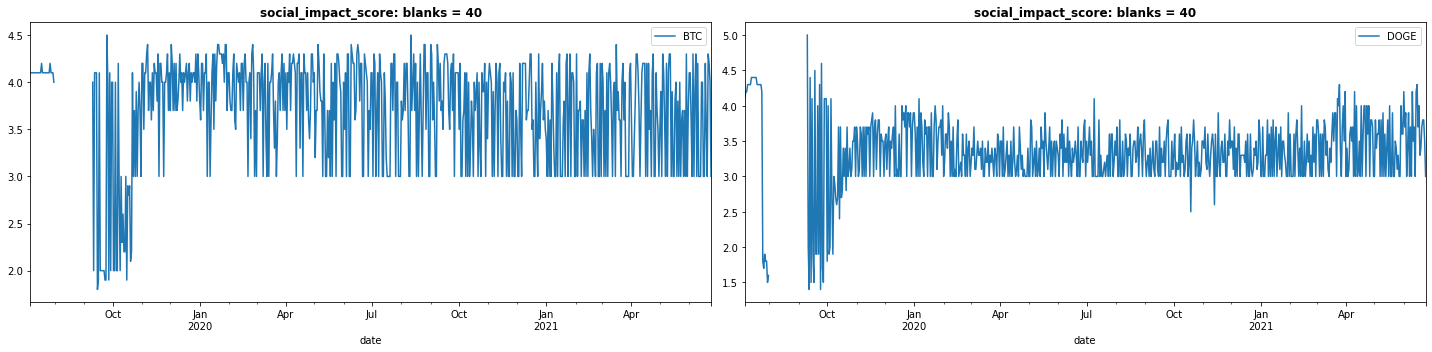

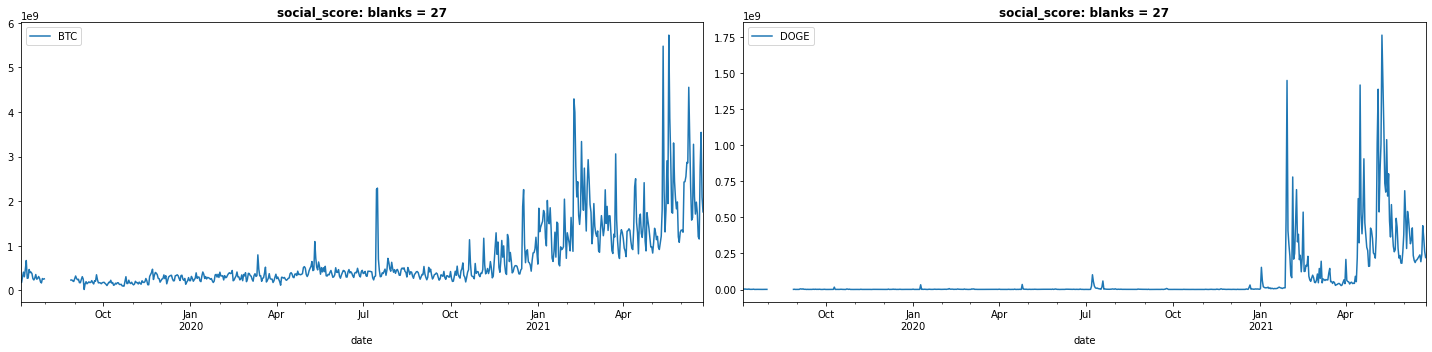

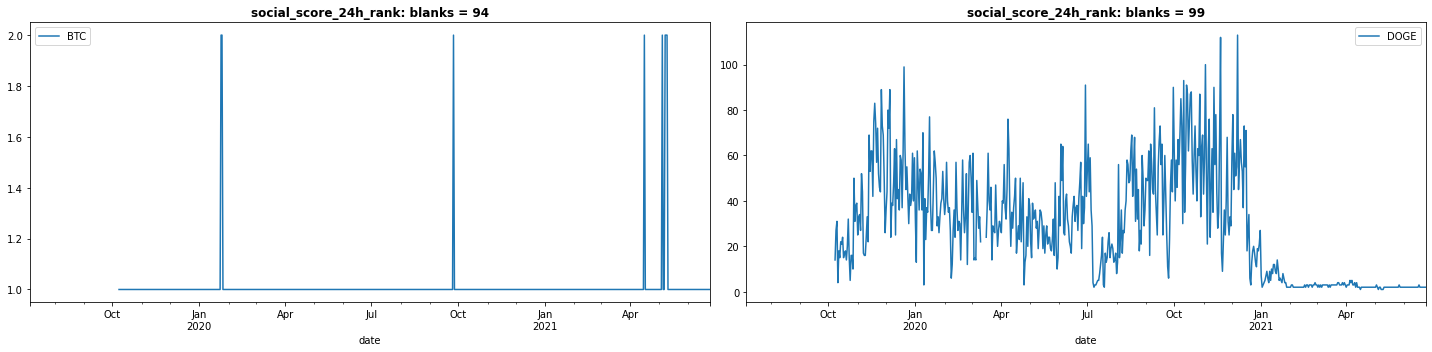

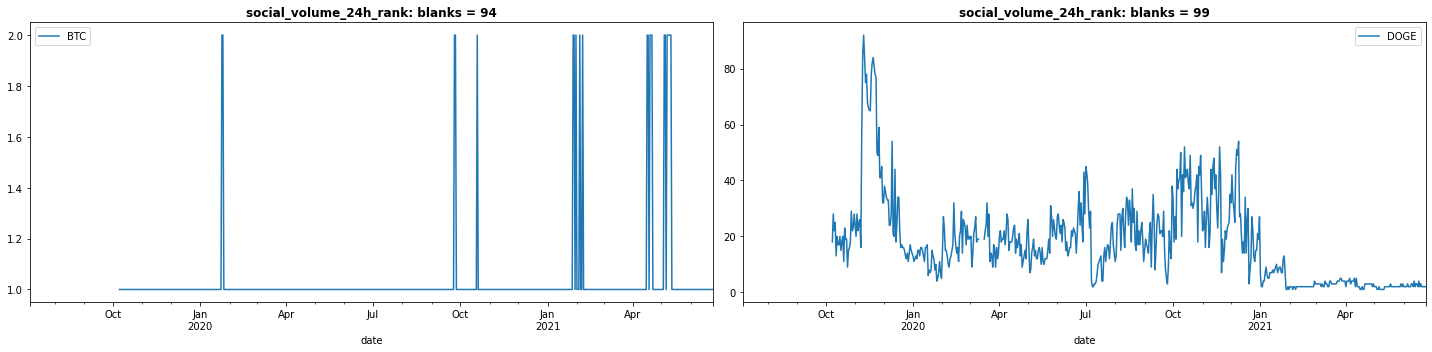

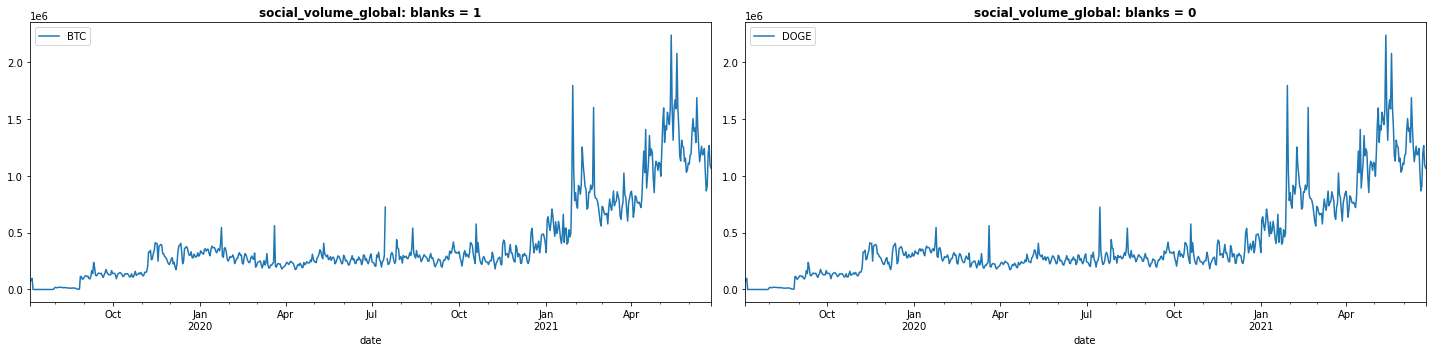

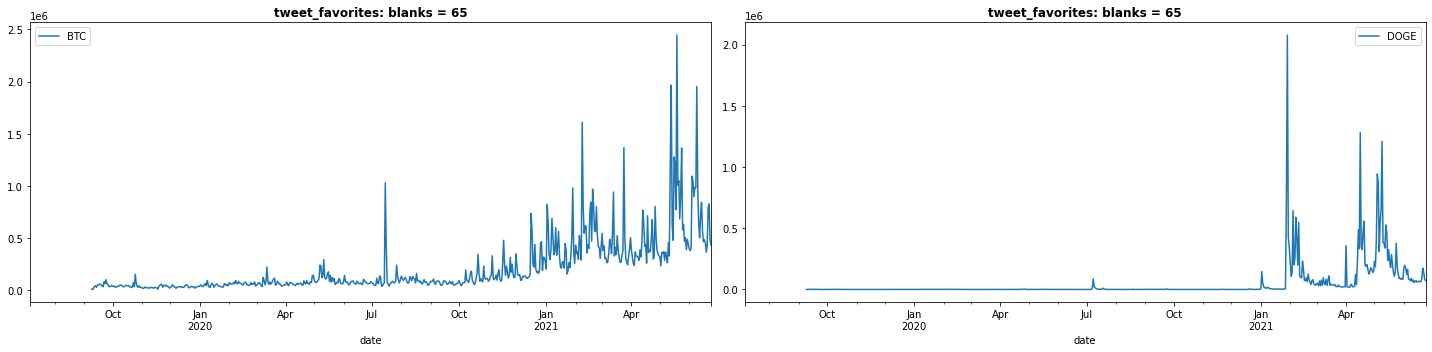

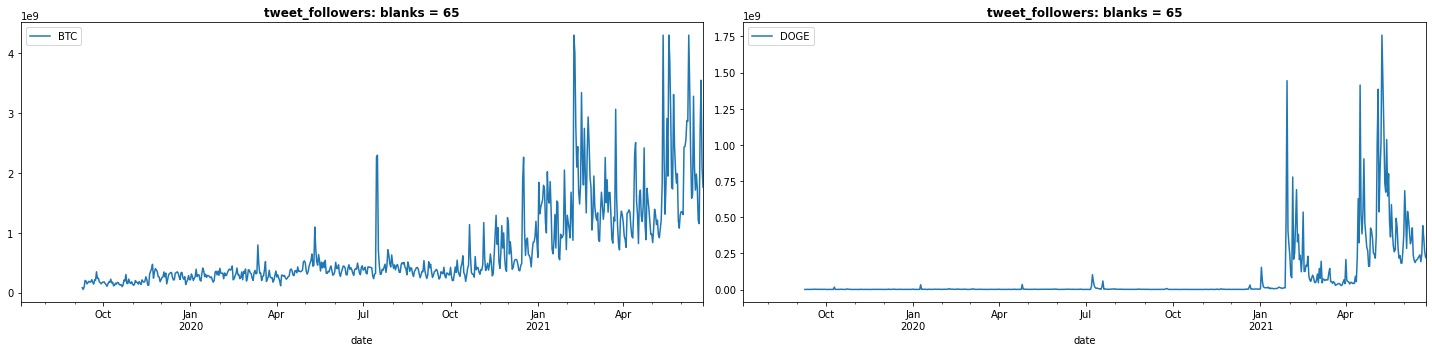

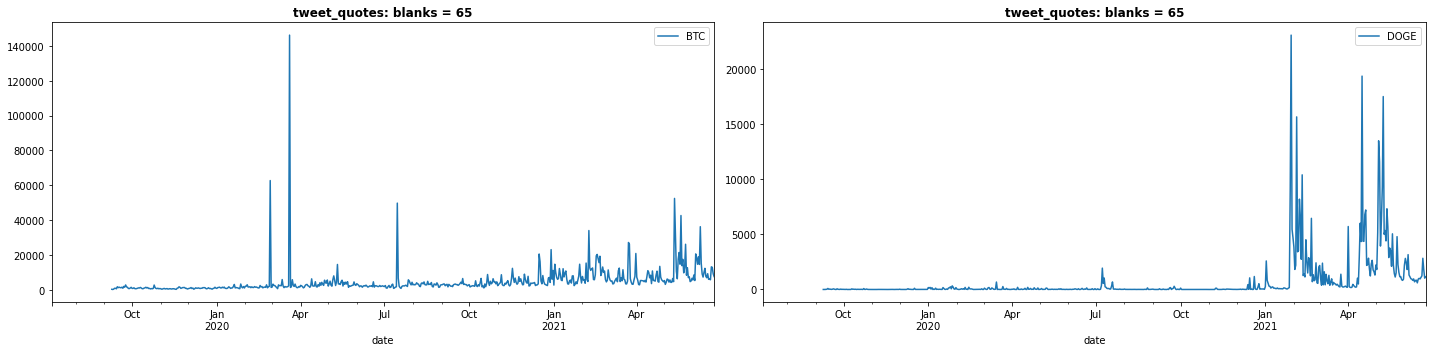

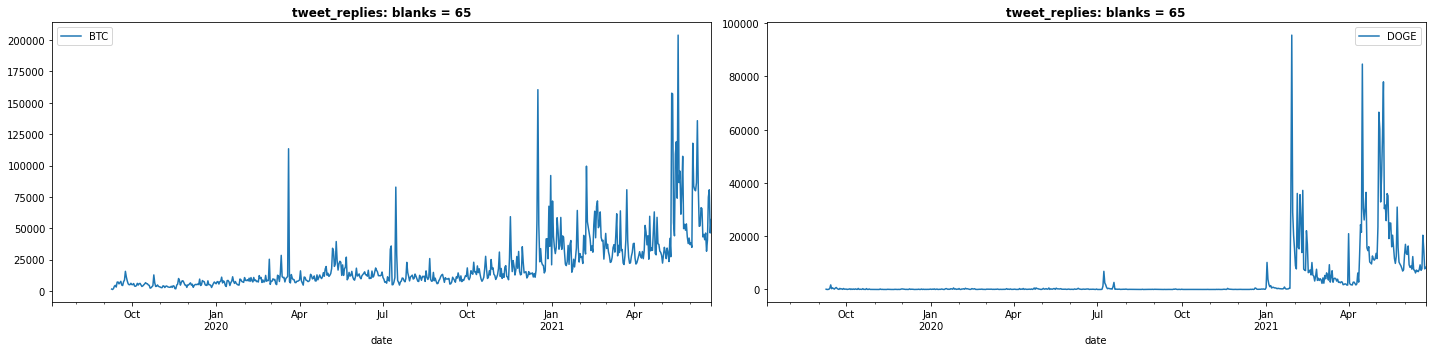

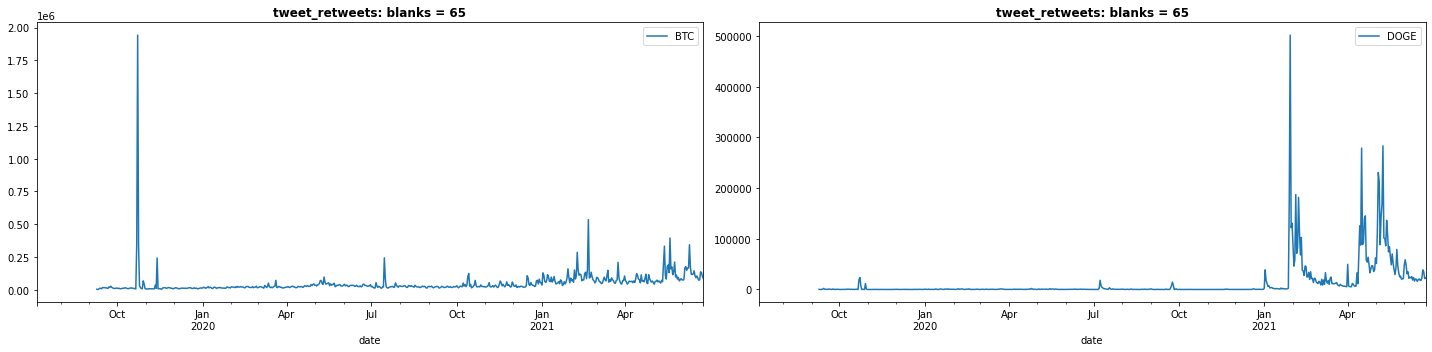

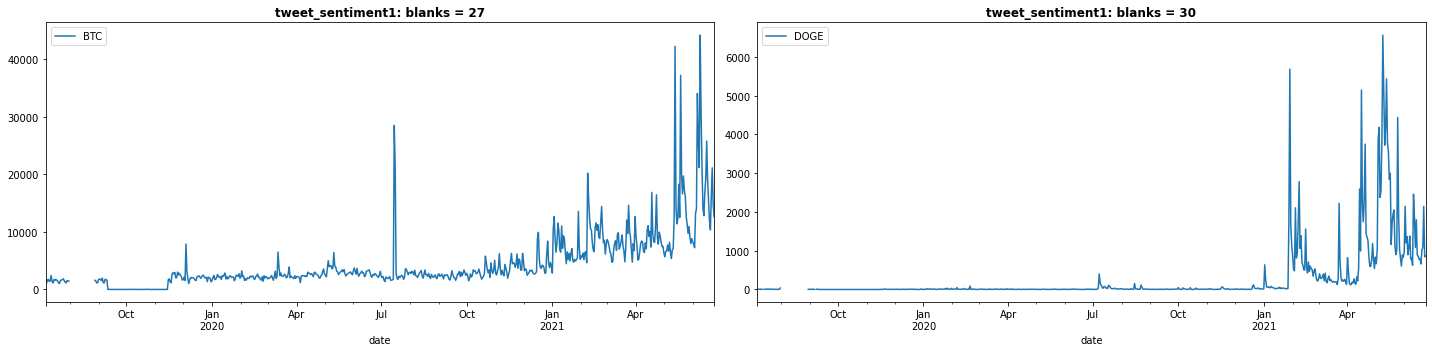

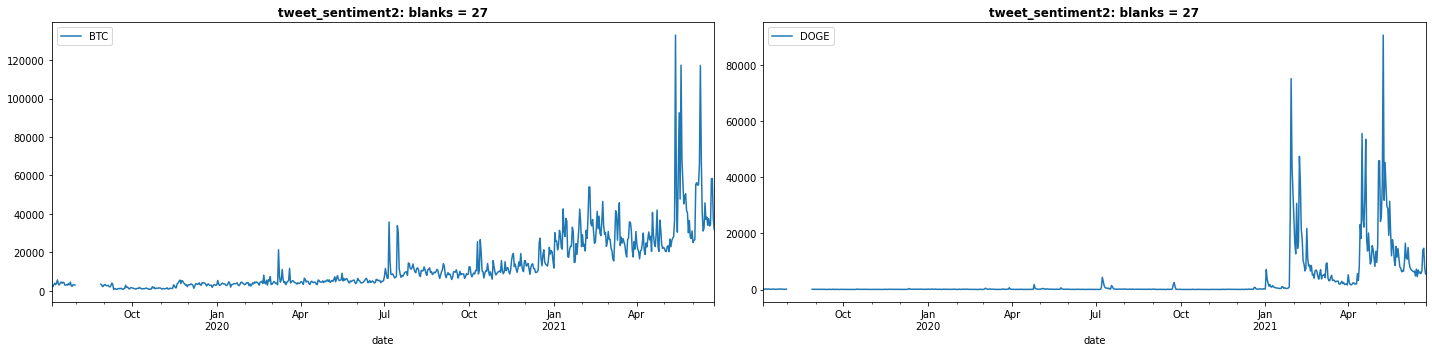

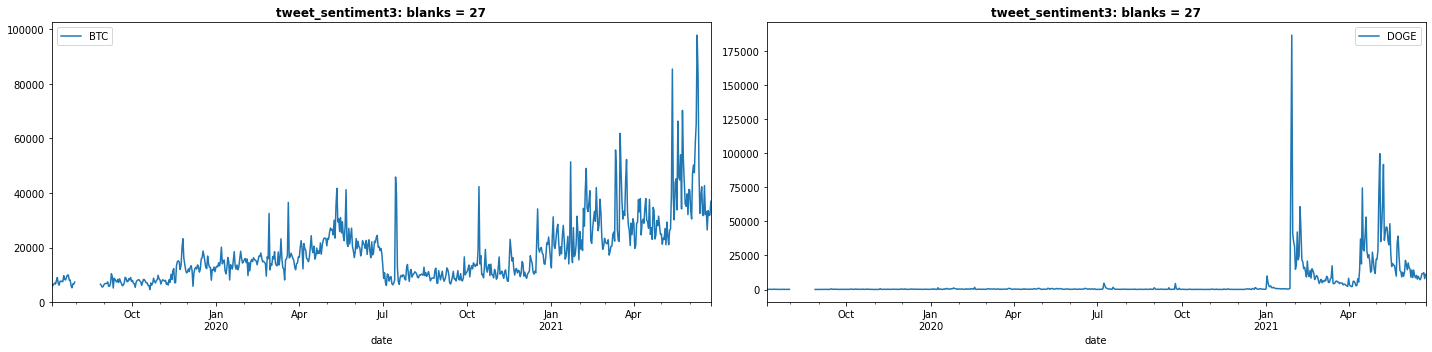

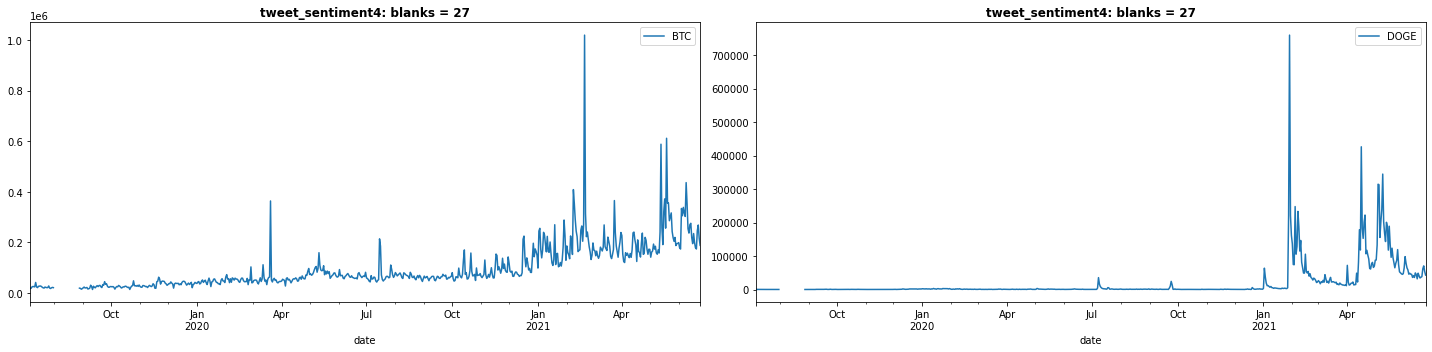

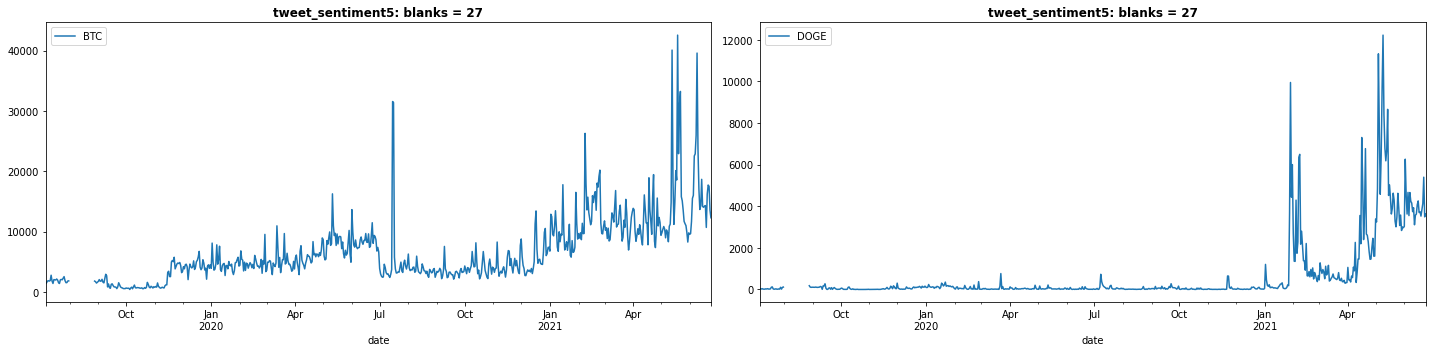

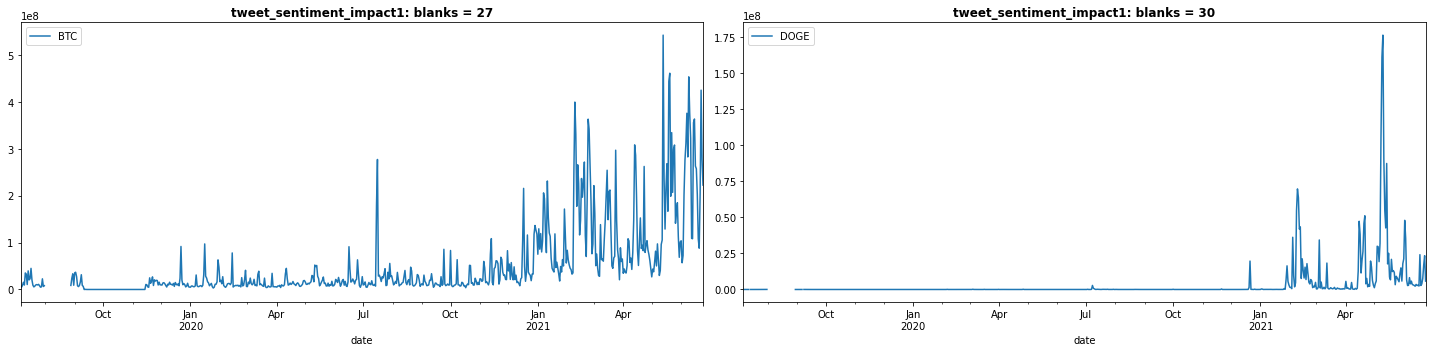

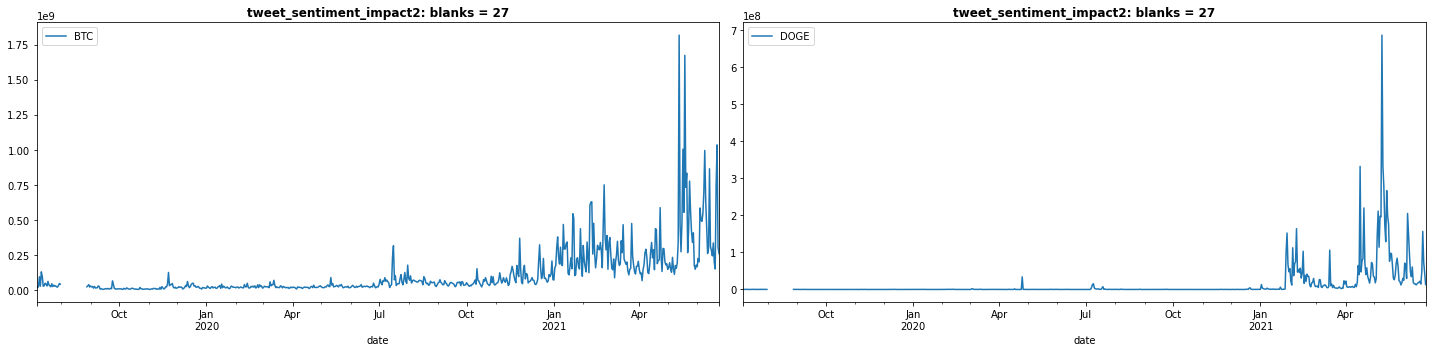

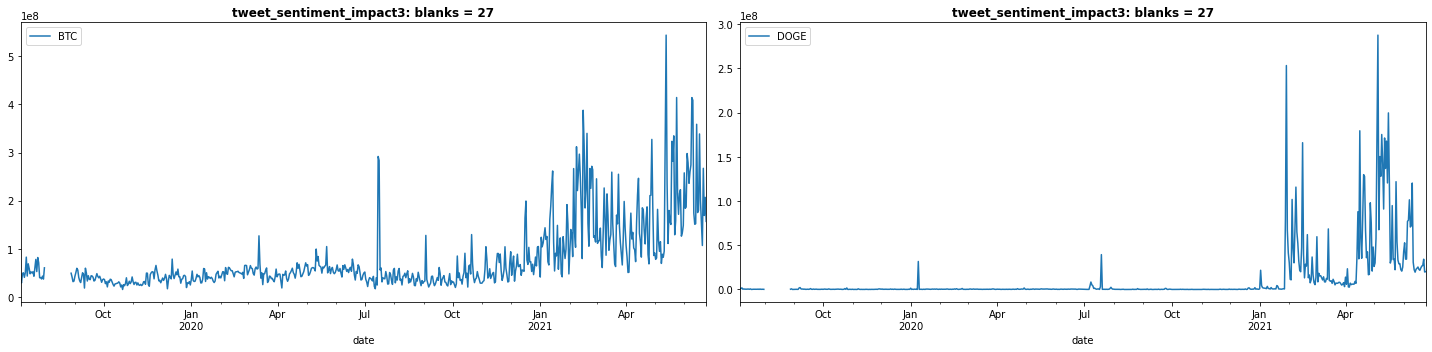

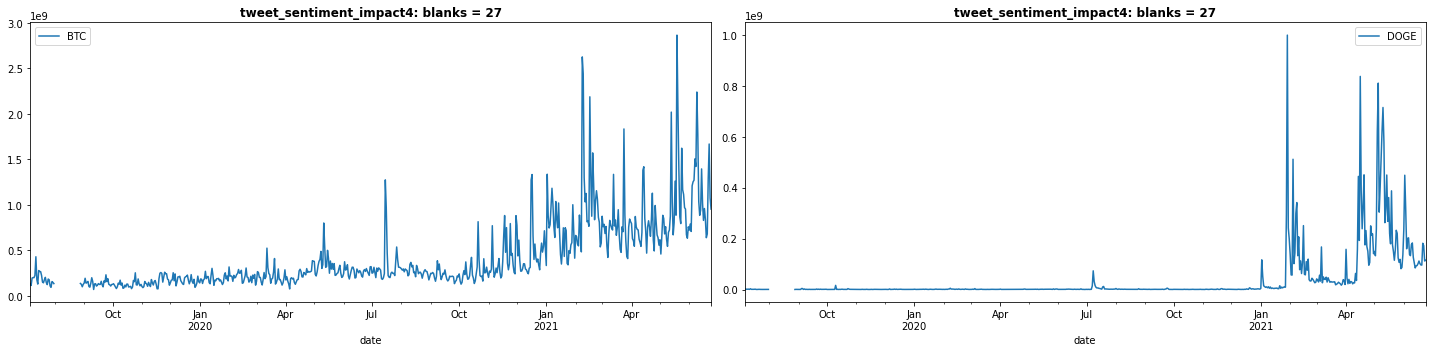

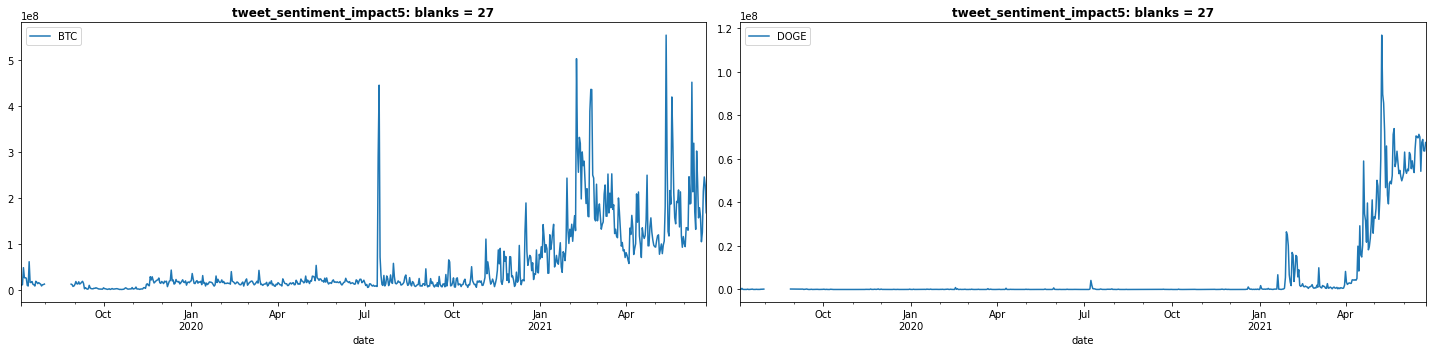

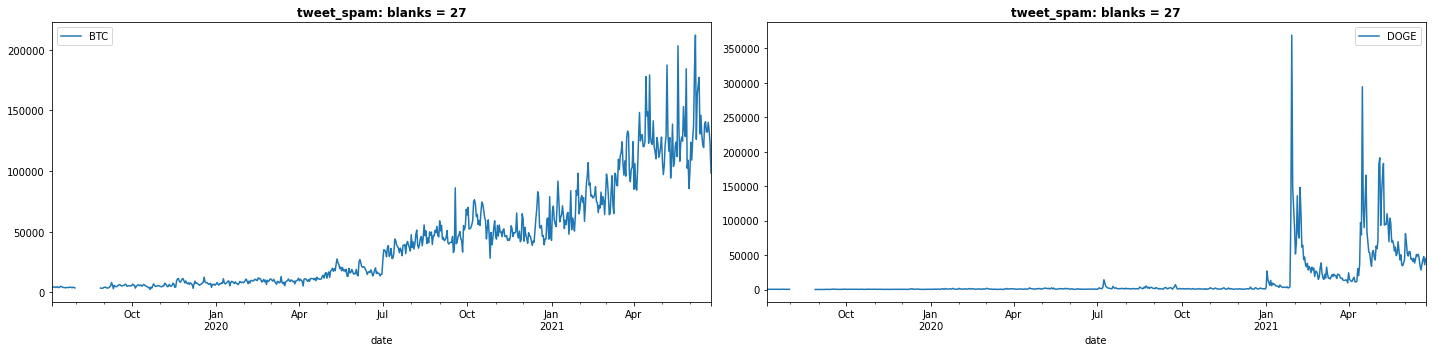

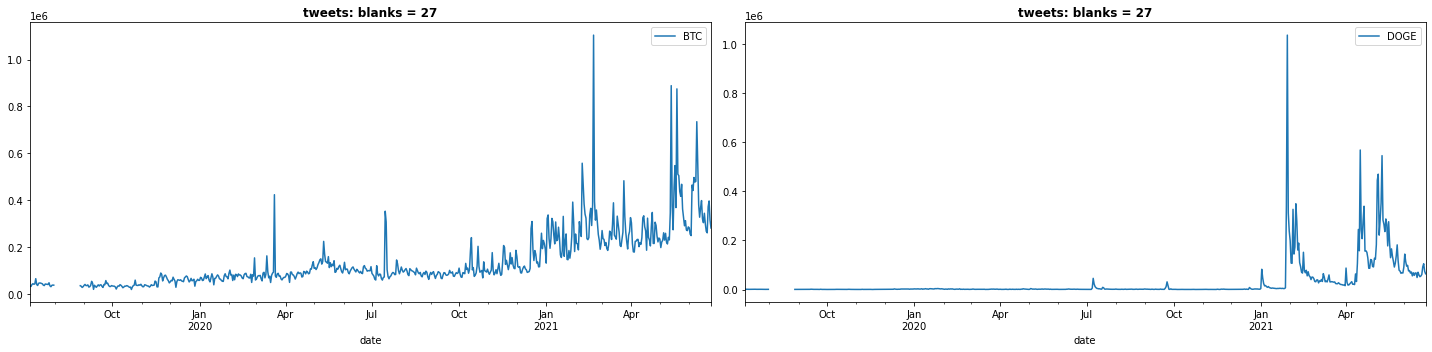

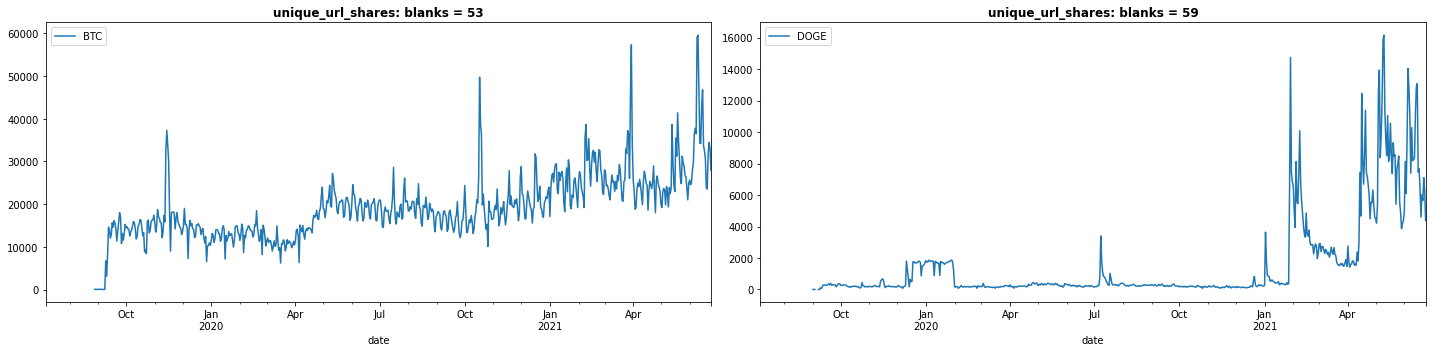

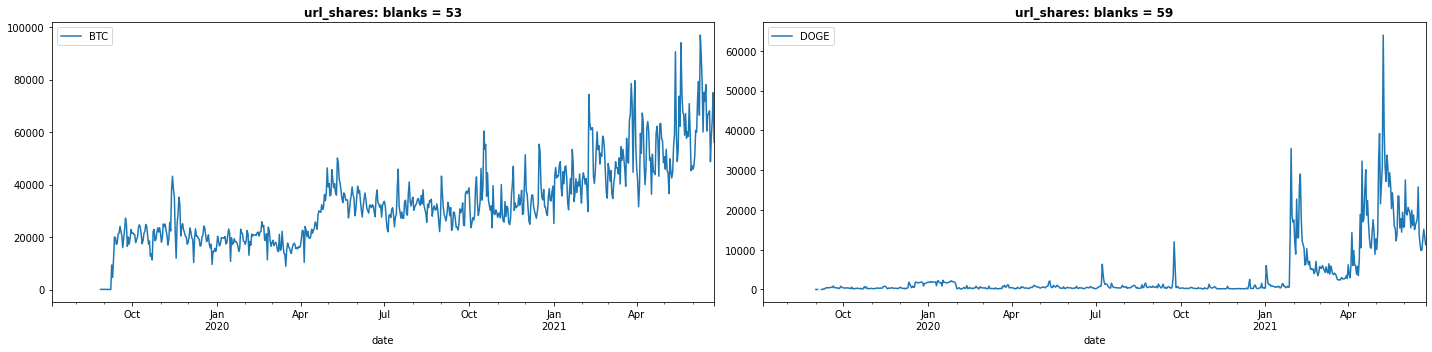

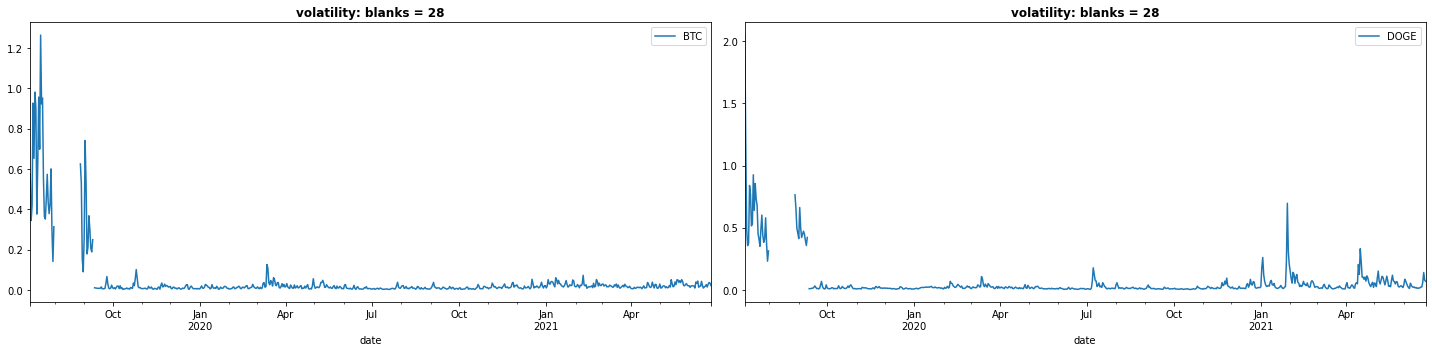

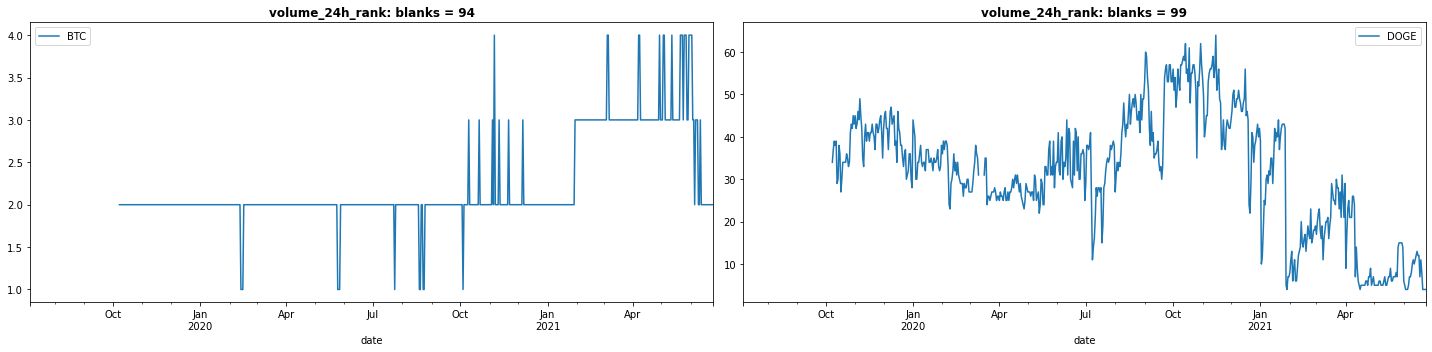

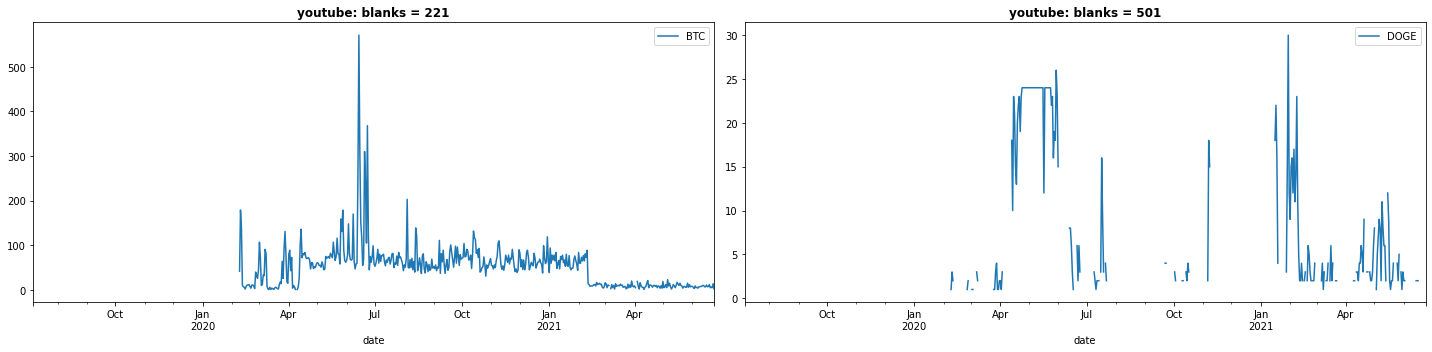

In [9]:
for col in sorted(blanks_set):
    fig, axes = plt.subplots(1,len(coins), figsize=(20,5))
    for i, coin in enumerate(coins):
        blanks = str(dfs[coin][col].isna().sum())
        ax = axes[i]
        dfs[coin][col].plot(ax=ax, label=coin)
        ax.set_title(col + ": blanks = " + blanks, fontweight='bold', size=12)
        ax.legend()
    plt.tight_layout()
    plt.show()

Most of the metrics are either missing data at the beginning of the time series or have a gap of 27-41 days in the Aug 2019 - Oct 2019 timeframe.

`medium` metric appears to be newer that started in Feb 2020 and also has intermittent blanks for DOGE.  This could be that DOGE was not as popular until recent.  Replace with zero but in the modeling staging may need to just exclude these 2 metrics.

`news` for DOGE has intermittent missing values so will replace with zero.

`search_average` metric appears to have been removed and is not populated after May 2020 so this column will be dropped.

`sentiment_absolute` metric is 3 for all coins so this column will be dropped.

`social_dominance` metric appears to no longer being populated with zeroes from Aug 2019.

`youtube` metric also appears to be newer that started in Feb 2020 so this may have been added with `medium`.

## 1.3 Data Cleaning

In [10]:
# Go back to November 2019 to include most social media metrics
btc = dfs['BTC'][dfs['BTC'].index >= '2019-11-01'].copy()

drop_cols = ['alt_rank_hour_average', 'search_average', 'sentiment_absolute', 'social_dominance']

btc = btc.drop(drop_cols, axis=1, errors='ignore')

zero_cols = ['medium', 'news', 'youtube']

btc[zero_cols] = btc[zero_cols].fillna(0)

btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 2019-11-01 to 2021-06-24
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 602 non-null    int64  
 1   time                     602 non-null    int64  
 2   open                     602 non-null    float64
 3   close                    602 non-null    float64
 4   high                     602 non-null    float64
 5   low                      602 non-null    float64
 6   volume                   602 non-null    float64
 7   market_cap               602 non-null    float64
 8   url_shares               602 non-null    float64
 9   unique_url_shares        602 non-null    float64
 10  reddit_posts             602 non-null    int64  
 11  reddit_posts_score       602 non-null    float64
 12  reddit_comments          602 non-null    int64  
 13  reddit_comments_score    602 non-null    float64
 14  tweets 

`social_volume_global` is only missing 1 value so will interpolate the gap in the time series.

In [11]:
# Interpolate the 1 missing blank for social_volume_global
btc['social_volume_global'] = btc['social_volume_global'].interpolate().round()

In [12]:
btc.isna().sum()

asset_id                   0
time                       0
open                       0
close                      0
high                       0
low                        0
volume                     0
market_cap                 0
url_shares                 0
unique_url_shares          0
reddit_posts               0
reddit_posts_score         0
reddit_comments            0
reddit_comments_score      0
tweets                     0
tweet_spam                 0
tweet_followers            0
tweet_quotes               0
tweet_retweets             0
tweet_replies              0
tweet_favorites            0
tweet_sentiment1           0
tweet_sentiment2           0
tweet_sentiment3           0
tweet_sentiment4           0
tweet_sentiment5           0
tweet_sentiment_impact1    0
tweet_sentiment_impact2    0
tweet_sentiment_impact3    0
tweet_sentiment_impact4    0
tweet_sentiment_impact5    0
social_score               0
average_sentiment          0
sentiment_relative         0
news          

No missing values for BTC.

In [13]:
# Go back to November 2019 to include most social media metrics
doge = dfs['DOGE'][dfs['DOGE'].index >= '2019-11-01'].copy()

doge = doge.drop(drop_cols, axis=1, errors='ignore')

doge[zero_cols] = doge[zero_cols].fillna(0)

doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 2019-11-01 to 2021-06-24
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 602 non-null    int64  
 1   time                     602 non-null    int64  
 2   open                     602 non-null    float64
 3   close                    602 non-null    float64
 4   high                     602 non-null    float64
 5   low                      602 non-null    float64
 6   volume                   602 non-null    float64
 7   market_cap               602 non-null    float64
 8   url_shares               602 non-null    float64
 9   unique_url_shares        602 non-null    float64
 10  reddit_posts             602 non-null    int64  
 11  reddit_posts_score       602 non-null    float64
 12  reddit_comments          602 non-null    int64  
 13  reddit_comments_score    602 non-null    float64
 14  tweets 

The rank columns have 5 missing values so let's explore that more closely.

In [14]:
rank_cols = ['alt_rank','alt_rank_30d','market_cap_rank','percent_change_24h_rank',
             'volume_24h_rank','social_volume_24h_rank', 'social_score_24h_rank']

doge[doge[rank_cols].isna().any(axis=1)]

asset_id        time      open     close      high       low  \
date                                                                       
2020-03-11        29  1583884800  0.002148  0.002221  0.002298  0.002143   
2020-03-12        29  1583971200  0.001367  0.001530  0.001581  0.001317   
2020-03-13        29  1584057600  0.001792  0.001780  0.001892  0.001656   
2020-03-14        29  1584144000  0.001663  0.001667  0.001716  0.001615   
2020-03-15        29  1584230400  0.001718  0.001671  0.001771  0.001618   

                 volume   market_cap  url_shares  unique_url_shares  ...  \
date                                                                 ...   
2020-03-11   70343744.0  270993593.0       250.0              145.0  ...   
2020-03-12  109765283.0  208024408.0       191.0              143.0  ...   
2020-03-13  158515449.0  206310014.0       158.0              122.0  ...   
2020-03-14   76827508.0  212119965.0       413.0              149.0  ...   
2020-03-15   83613513.0  212351008.0       254.0              132.0  ...   

            youtube  social_contributors  social_volume     price_btc  \
date                                                                    
2020-03-11      0.0                  879            874  2.790754e-07   
2020-03-12      0.0                  711           1293  3.103532e-07   
2020-03-13      0.0                 1042           1084  3.106498e-07   
2020-03-14      1.0                  865           1147  3.190493e-07   
2020-03-15      0.0                  867           1381  3.105080e-07   

            social_volume_global  market_cap_global  market_dominance  \
date                                                                    
2020-03-11                236169       2.247385e+11          0.120582   
2020-03-12                315800       1.389236e+11          0.149740   
2020-03-13                217481       1.612990e+11          0.127905   
2020-03-14                188433       1.486319e+11          0.142715   
2020-03-15                191585       1.535616e+11          0.138284   

            percent_change_24h      name  symbol  
date                                              
2020-03-11           -0.358905  Dogecoin    DOGE  
2020-03-12          -31.112112  Dogecoin    DOGE  
2020-03-13           16.339869  Dogecoin    DOGE  
2020-03-14           -6.348315  Dogecoin    DOGE  
2020-03-15            0.239952  Dogecoin    DOGE  

[5 rows x 58 columns]

The timeframe is sort of random from 3/11/20 - 3/15/20.

In [15]:
doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11       NaN           NaN              NaN                      NaN   
2020-03-12       NaN           NaN              NaN                      NaN   
2020-03-13       NaN           NaN              NaN                      NaN   
2020-03-14       NaN           NaN              NaN                      NaN   
2020-03-15       NaN           NaN              NaN                      NaN   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11              NaN                     NaN                    NaN  
2020-03-12              NaN                     NaN                    NaN  
2020-03-13              NaN                     NaN                    NaN  
2020-03-14              NaN                     NaN                    NaN  
2020-03-15              NaN                     NaN                    NaN  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

For DOGE there could have been an issue with the rankings during this timeframe so will interpolate the gap in the time series.

In [16]:
# Interpolate the 1 missing blank for social_volume_global
doge[rank_cols] = doge[rank_cols].interpolate().round()

doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11      20.0          24.0             30.0                    818.0   
2020-03-12      17.0          24.0             30.0                    735.0   
2020-03-13      13.0          24.0             30.0                    653.0   
2020-03-14       9.0          23.0             29.0                    571.0   
2020-03-15       6.0          23.0             29.0                    488.0   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11             31.0                    19.0                   22.0  
2020-03-12             31.0                    19.0                   23.0  
2020-03-13             31.0                    19.0                   23.0  
2020-03-14             31.0                    19.0                   23.0  
2020-03-15             31.0                    19.0                   24.0  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

In [17]:
doge.isna().sum()

asset_id                   0
time                       0
open                       0
close                      0
high                       0
low                        0
volume                     0
market_cap                 0
url_shares                 0
unique_url_shares          0
reddit_posts               0
reddit_posts_score         0
reddit_comments            0
reddit_comments_score      0
tweets                     0
tweet_spam                 0
tweet_followers            0
tweet_quotes               0
tweet_retweets             0
tweet_replies              0
tweet_favorites            0
tweet_sentiment1           0
tweet_sentiment2           0
tweet_sentiment3           0
tweet_sentiment4           0
tweet_sentiment5           0
tweet_sentiment_impact1    0
tweet_sentiment_impact2    0
tweet_sentiment_impact3    0
tweet_sentiment_impact4    0
tweet_sentiment_impact5    0
social_score               0
average_sentiment          0
sentiment_relative         0
news          

No missing values for DOGE.

## 1.4 Buy/Hold/Sell Decision

For this project I'm going to build 2 different models:

1. Time Series modeling for price predictions for the next 7 days.
2. Multi-class classification model for a Buy, Hold or Sell recommendation over a 7 day window from the most recent closing price.

The buy/hold/sell decision logic is based on a forward looking window.

Buy:
1. Maximum gain during the window is > the desired threshold
2. Change in close price from the start to end of window is higher (window candle is green)
3. Lowest price during the window is >= the low price for the current day

Sell:
1. Maximum loss during the window is < the desired threshold
2. Change in close price from the start to end of window is lower (window candle is red)
3. Highest price during the window is <= the high price for the current day

All else the decision is Hold.

In [18]:
# Apply forward looking window metrics to data
btc = window_metrics(btc, 7, 1, .05)
doge = window_metrics(doge, 7, 1, .05)

In [19]:
btc[btc.isna().any(axis=1)]

asset_id        time          open         close          high  \
date                                                                         
2021-06-18         1  1623974400  38171.112667  35952.022518  38171.112667   
2021-06-19         1  1624060800  35923.106265  35616.764153  36148.215133   
2021-06-20         1  1624147200  35599.380661  35564.107075  36016.049166   
2021-06-21         1  1624233600  35569.212970  31734.503463  35569.212970   
2021-06-22         1  1624320000  31749.512750  32491.402924  32881.418095   
2021-06-23         1  1624406400  32511.198598  33696.207288  34486.511500   
2021-06-24         1  1624492800  33699.118652  34705.312025  34883.623343   

                     low        volume    market_cap  url_shares  \
date                                                               
2021-06-18  35734.847051  4.370563e+10  7.065849e+11     67149.0   
2021-06-19  35031.096436  3.592948e+10  6.697717e+11     68061.0   
2021-06-20  34117.774975  4.209000e+10  6.646636e+11     48700.0   
2021-06-21  31441.573098  6.045249e+10  6.675847e+11     58378.0   
2021-06-22  29510.735435  6.978584e+10  5.980058e+11     64831.0   
2021-06-23  32378.874674  4.926090e+10  6.295481e+11     75021.0   
2021-06-24  32833.701516  3.579437e+10  6.229915e+11     56117.0   

            unique_url_shares  ...  close_max_7d  close_loss_7d  \
date                           ...                                
2021-06-18            30610.0  ...  38171.112667      -0.179163   
2021-06-19            23786.0  ...  36148.215133      -0.171437   
2021-06-20            23554.0  ...  36016.049166      -0.170210   
2021-06-21            31966.0  ...  35569.212970      -0.070074   
2021-06-22            34436.0  ...  34883.623343      -0.091737   
2021-06-23            32974.0  ...  34883.623343      -0.039094   
2021-06-24            27905.0  ...  34883.623343      -0.053929   

            close_gain_7d  close_change_7d  close_percent_change_7d  decision  \
date                                                                            
2021-06-18       0.061724              NaN                      NaN      Hold   
2021-06-19       0.014921              NaN                      NaN      Hold   
2021-06-20       0.012708              NaN                      NaN      Hold   
2021-06-21       0.120837              NaN                      NaN      Hold   
2021-06-22       0.073626              NaN                      NaN      Hold   
2021-06-23       0.035239              NaN                      NaN      Hold   
2021-06-24       0.005138              NaN                      NaN      Hold   

            color  buy  sell  hold  
date                                
2021-06-18   Grey    0     0     1  
2021-06-19   Grey    0     0     1  
2021-06-20   Grey    0     0     1  
2021-06-21   Grey    0     0     1  
2021-06-22   Grey    0     0     1  
2021-06-23   Grey    0     0     1  
2021-06-24   Grey    0     0     1  

[7 rows x 72 columns]

Blanks are related to 7 day forward window for decision.

In [20]:
# Drop blanks
btc = btc.dropna()
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2019-11-01 to 2021-06-17
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 595 non-null    int64  
 1   time                     595 non-null    int64  
 2   open                     595 non-null    float64
 3   close                    595 non-null    float64
 4   high                     595 non-null    float64
 5   low                      595 non-null    float64
 6   volume                   595 non-null    float64
 7   market_cap               595 non-null    float64
 8   url_shares               595 non-null    float64
 9   unique_url_shares        595 non-null    float64
 10  reddit_posts             595 non-null    int64  
 11  reddit_posts_score       595 non-null    float64
 12  reddit_comments          595 non-null    int64  
 13  reddit_comments_score    595 non-null    float64
 14  tweets 

In [21]:
doge[doge.isna().any(axis=1)]

asset_id        time      open     close      high       low  \
date                                                                       
2021-06-18        29  1623974400  0.307840  0.294709  0.309271  0.282679   
2021-06-19        29  1624060800  0.293805  0.288313  0.299749  0.286248   
2021-06-20        29  1624147200  0.288094  0.282005  0.291741  0.257567   
2021-06-21        29  1624233600  0.286502  0.217220  0.288946  0.208370   
2021-06-22        29  1624320000  0.178876  0.190976  0.217457  0.163580   
2021-06-23        29  1624406400  0.191485  0.234789  0.245753  0.185224   
2021-06-24        29  1624492800  0.236021  0.267343  0.262795  0.223699   

                  volume    market_cap  url_shares  unique_url_shares  ...  \
date                                                                   ...   
2021-06-18  2.960318e+09  3.998770e+10     11376.0             6344.0  ...   
2021-06-19  1.581403e+09  3.830465e+10      9798.0             4598.0  ...   
2021-06-20  3.071058e+09  3.696824e+10      9918.0             6011.0  ...   
2021-06-21  7.774900e+08  3.624238e+10     12705.0             5646.0  ...   
2021-06-22  2.008609e+08  2.342241e+10     15134.0             7103.0  ...   
2021-06-23  6.177365e+08  2.521771e+10     13345.0             6278.0  ...   
2021-06-24  5.482774e+09  3.030973e+10     11235.0             4378.0  ...   

            close_max_7d  close_loss_7d  close_gain_7d  close_change_7d  \
date                                                                      
2021-06-18      0.309271      -0.444943       0.049414              NaN   
2021-06-19      0.299749      -0.432629       0.039668              NaN   
2021-06-20      0.291741      -0.419938       0.034526              NaN   
2021-06-21      0.288946      -0.246936       0.330203              NaN   
2021-06-22      0.262795      -0.143452       0.376062              NaN   
2021-06-23      0.262795      -0.211104       0.119282              NaN   
2021-06-24      0.262795      -0.163251      -0.017013              NaN   

            close_percent_change_7d  decision  color  buy  sell  hold  
date                                                                   
2021-06-18                      NaN      Hold   Grey    0     0     1  
2021-06-19                      NaN      Hold   Grey    0     0     1  
2021-06-20                      NaN      Hold   Grey    0     0     1  
2021-06-21                      NaN      Hold   Grey    0     0     1  
2021-06-22                      NaN      Hold   Grey    0     0     1  
2021-06-23                      NaN      Hold   Grey    0     0     1  
2021-06-24                      NaN      Hold   Grey    0     0     1  

[7 rows x 72 columns]

Similar to BTC, DOGE blanks are related to 7 day forward window for decision.

In [22]:
# Drop blanks
doge = doge.dropna()
doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2019-11-01 to 2021-06-17
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 595 non-null    int64  
 1   time                     595 non-null    int64  
 2   open                     595 non-null    float64
 3   close                    595 non-null    float64
 4   high                     595 non-null    float64
 5   low                      595 non-null    float64
 6   volume                   595 non-null    float64
 7   market_cap               595 non-null    float64
 8   url_shares               595 non-null    float64
 9   unique_url_shares        595 non-null    float64
 10  reddit_posts             595 non-null    int64  
 11  reddit_posts_score       595 non-null    float64
 12  reddit_comments          595 non-null    int64  
 13  reddit_comments_score    595 non-null    float64
 14  tweets 

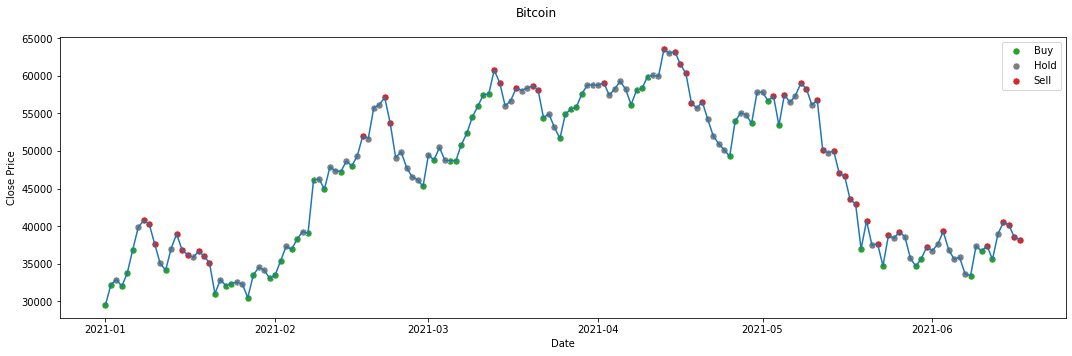

In [23]:
# Plot 2021 close prices for BTC
fig, ax = plt.subplots(figsize=(15,5))
btc_filtered = btc.loc['2021-01-01':]
decision_plot(btc_filtered, ax)

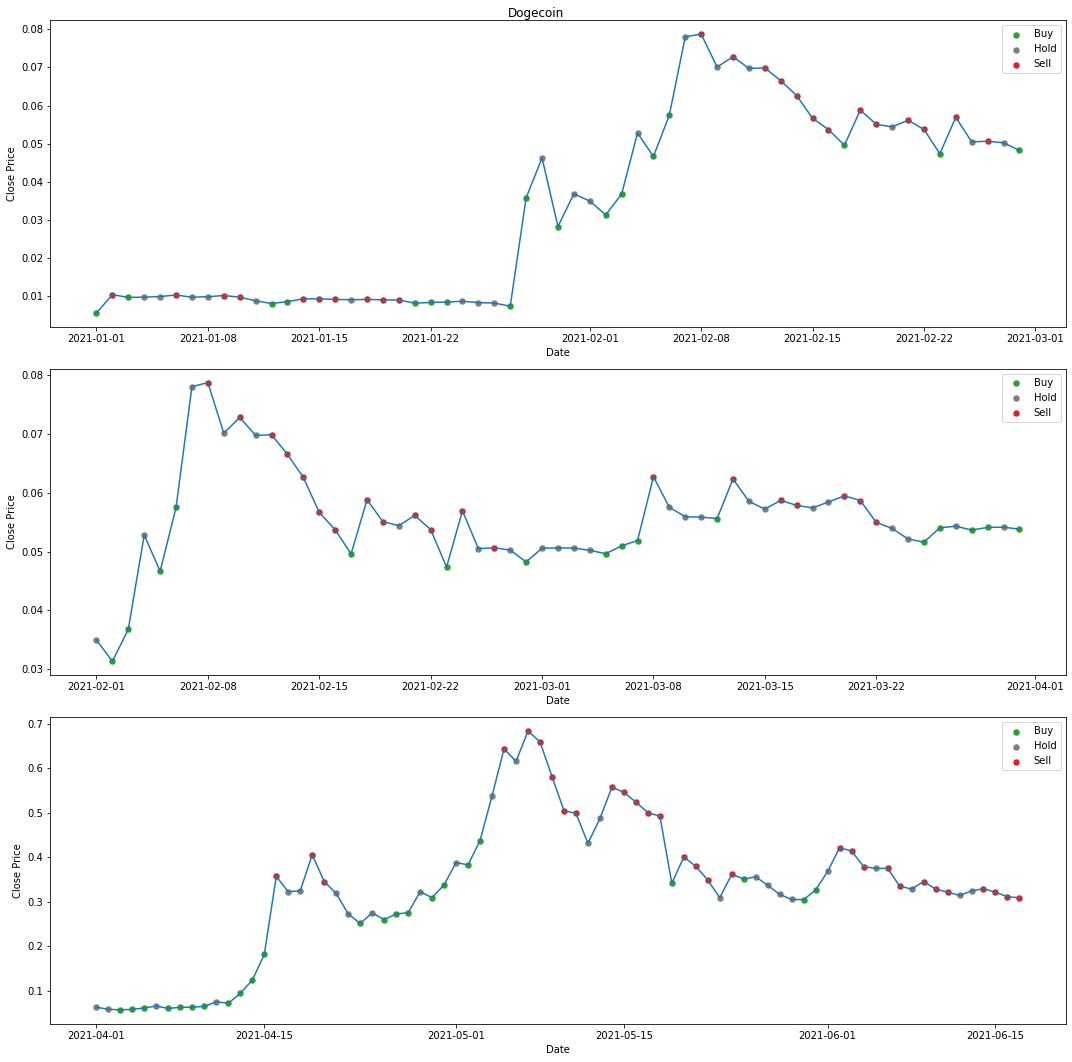

In [24]:
# Plot 2021 close prices for DOGE
fig, ax = plt.subplots(3,1, figsize=(15,15))
doge_filtered = doge.loc['2021-01-01':'2021-02-28']
decision_plot(doge_filtered, ax[0])
doge_filtered = doge.loc['2021-02-01':'2021-03-31']
decision_plot(doge_filtered, ax[1])
doge_filtered = doge.loc['2021-04-01':]
decision_plot(doge_filtered, ax[2])

The Buy/Hold/Sell decision logic for BTC is pretty effective at recommending to buy at the bottom of the trough or as the price is going up and then recommending to sell at the peak or just before the peak.  I split up the DOGE charts just to get a better visual due to large price swings since January 2021.

## 1.5 Save Data

I will save the data for the exploratory data analysis and modeling stages to avoid the time period changing.

In [25]:
import os
intermediate_dir = r'..\data\intermediate'
btc.to_csv(os.path.join(intermediate_dir, 'btc.csv'))
doge.to_csv(os.path.join(intermediate_dir, 'doge.csv'))